## Notebook Imports

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

##warnings.filterwarnings('ignore')
sns.set()

## Gather Data

In [2]:
df = pd.read_csv('Data_for_UCI_named.csv')

## Data Exploration

In [3]:
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


## Cleaning Data - Check For Missing Values

In [4]:
df.isna().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

## Visualizing The Distribution Of Target

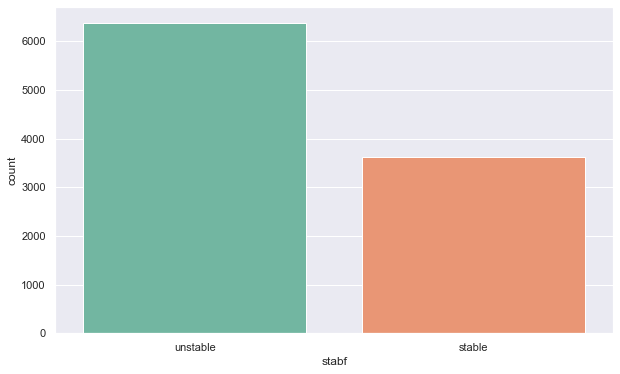

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(x='stabf', data=df, palette="Set2")

## Descriptive Statistics

In [6]:
df.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.250000,5.250001,5.250004,5.249997,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731
std,2.742548,2.742549,2.742549,2.742556,0.752160,0.433035,0.433035,0.433035,0.274256,0.274255,0.274255,0.274255,0.036919
min,0.500793,0.500141,0.500788,0.500473,1.582590,-1.999891,-1.999945,-1.999926,0.050009,0.050053,0.050054,0.050028,-0.080760
25%,2.874892,2.875140,2.875522,2.874950,3.218300,-1.624901,-1.625025,-1.624960,0.287521,0.287552,0.287514,0.287494,-0.015557
50%,5.250004,5.249981,5.249979,5.249734,3.751025,-1.249966,-1.249974,-1.250007,0.525009,0.525003,0.525015,0.525002,0.017142
75%,7.624690,7.624893,7.624948,7.624838,4.282420,-0.874977,-0.875043,-0.875065,0.762435,0.762490,0.762440,0.762433,0.044878
max,9.999469,9.999837,9.999450,9.999443,5.864418,-0.500108,-0.500072,-0.500025,0.999937,0.999944,0.999982,0.999930,0.109403


## Training And Test Data Split

In [7]:
X = df.drop(['stab', 'stabf'], axis=1)
y = df['stabf']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
y_train

2694    unstable
5140    unstable
2568    unstable
3671    unstable
7427    unstable
          ...   
2895      stable
7813      stable
905     unstable
5192    unstable
235       stable
Name: stabf, Length: 8000, dtype: object

### Normalizing Dataset

In [9]:
scaler = StandardScaler()

## TRAIN SET
normalized_train_df = scaler.fit_transform(X_train)
normalized_train_df = pd.DataFrame(normalized_train_df, columns=X_train.columns)

## TEST SET
normalized_test_df = scaler.transform(X_test)
normalized_test_df = pd.DataFrame(normalized_test_df, columns=X_test.columns)

In [10]:
normalized_test_df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,0.593951,-0.412733,1.503924,1.116943,0.403423,-1.492971,-0.785033,1.566781,-0.901007,1.167203,-1.507330,1.084726
1,0.202190,0.374416,-0.188800,-0.522268,-0.225967,-1.058483,0.420047,1.028627,-1.625721,-0.395660,1.414651,1.226011
2,-1.079044,-0.313745,-0.884634,0.017080,-0.943122,0.112653,0.801335,0.733004,1.457108,-1.438495,0.651821,-1.682168
3,-0.083120,-1.107327,0.372805,-1.708152,0.753990,-1.637972,0.403805,-0.088036,0.083322,-1.672322,-0.357714,1.055865
4,0.873921,1.438466,0.086662,1.715037,-0.153880,-0.007015,-0.197053,0.472315,0.136549,-1.469731,0.956396,-0.819727
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.119679,-0.675220,-1.382912,1.287865,0.249565,-0.803325,0.734497,-0.369263,0.485786,-0.115528,-1.264683,-1.283117
1996,-1.077913,-0.808691,1.033449,0.337636,-0.166587,0.340913,0.988085,-1.035753,0.952386,0.892766,-1.062502,-1.094114
1997,0.947825,-1.663727,-1.653920,0.532665,-1.518329,1.590144,0.091613,0.974455,-1.233963,0.126391,0.573445,1.319350
1998,-1.120235,0.193979,-0.237805,0.421570,-1.162671,0.738702,0.027367,1.265833,1.524336,0.794087,-1.362323,-0.801971


## Classifiers

### Random Forest Classifier

In [11]:
rnd_clf = RandomForestClassifier(random_state=1)
rnd_clf.fit(normalized_train_df, y_train)
y_pred_rf = rnd_clf.predict(normalized_test_df)

In [12]:
cnf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_rf, labels=['stable', 'unstable'])
cnf = pd.DataFrame(cnf_mat)
cnf.columns = ['Predicted Stable', 'Predicted Unstable']
cnf = cnf.rename(index={0: 'Actual STABLE', 1: 'Actual UNSTABLE'})
cnf

,Predicted Stable,Predicted Unstable
Actual STABLE,625,87
Actual UNSTABLE,55,1233


In [30]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_rf)
print(accuracy)

0.929


In [13]:
print(classification_report(y_true=y_test, y_pred=y_pred_rf))

              precision    recall  f1-score   support

      stable       0.92      0.88      0.90       712
    unstable       0.93      0.96      0.95      1288

    accuracy                           0.93      2000
   macro avg       0.93      0.92      0.92      2000
weighted avg       0.93      0.93      0.93      2000



### Extra Tress Classifier

In [49]:
ext_clf = ExtraTreesClassifier(random_state=1)
ext_clf.fit(normalized_train_df, y_train)
y_pred_ext = ext_clf.predict(normalized_test_df)

In [50]:
cnf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_ext, labels=['stable', 'unstable'])
cnf = pd.DataFrame(cnf_mat)
cnf.columns = ['Predicted Stable', 'Predicted Unstable']
cnf = cnf.rename(index={0: 'Actual STABLE', 1: 'Actual UNSTABLE'})
cnf

,Predicted Stable,Predicted Unstable
Actual STABLE,606,106
Actual UNSTABLE,38,1250


In [51]:
print(classification_report(y_true=y_test, y_pred=y_pred_ext, digits=4))

              precision    recall  f1-score   support

      stable     0.9410    0.8511    0.8938       712
    unstable     0.9218    0.9705    0.9455      1288

    accuracy                         0.9280      2000
   macro avg     0.9314    0.9108    0.9197      2000
weighted avg     0.9287    0.9280    0.9271      2000



### Improved Extra Trees Classifier

In [36]:
## Setup the parameters and distributions to sample
n_estimators = [50, 100, 300, 500, 1000]
min_samples_split = [2, 3, 5, 7, 9]
min_samples_leaf = [1, 2, 4, 6, 8]
max_features = ['auto', 'sqrt', 'log2', None] 

hyperparameter_grid = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

## Instantiate the RandomizedSearchCV
tree_cv = RandomizedSearchCV(ext_clf, hyperparameter_grid, random_state=1)
tree_cv.fit(normalized_train_df, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None}
Best score is 0.92425


In [38]:
y_pred_tree = tree_cv.predict(normalized_test_df)
print(classification_report(y_true=y_test, y_pred=y_pred_tree, digits=4))

              precision    recall  f1-score   support

      stable     0.9214    0.8722    0.8961       712
    unstable     0.9314    0.9589    0.9449      1288

    accuracy                         0.9280      2000
   macro avg     0.9264    0.9155    0.9205      2000
weighted avg     0.9278    0.9280    0.9275      2000



In [39]:
## Setup the parameters and distributions to sample
n_estimators = [50, 100, 300, 500, 1000]
min_samples_split = [2, 3, 5, 7, 9]
min_samples_leaf = [1, 2, 4, 6, 8]
max_features = ['auto', 'sqrt', 'log2', None] 

hyperparameter_grid = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

## Instantiate the RandomizedSearchCV
tree_cv_1 = RandomizedSearchCV(ext_clf, hyperparameter_grid, random_state=1, cv=5, n_iter=10, scoring="accuracy", n_jobs=-1,verbose=1)
tree_cv_1.fit(normalized_train_df, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv_1.best_params_))
print("Best score is {}".format(tree_cv_1.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.8min finished


Tuned Decision Tree Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None}
Best score is 0.925


In [40]:
y_pred_tree_1 = tree_cv_1.predict(normalized_test_df)
print(classification_report(y_true=y_test, y_pred=y_pred_tree_1, digits=4))

              precision    recall  f1-score   support

      stable     0.9230    0.8750    0.8983       712
    unstable     0.9328    0.9596    0.9460      1288

    accuracy                         0.9295      2000
   macro avg     0.9279    0.9173    0.9222      2000
weighted avg     0.9293    0.9295    0.9291      2000



In [46]:
ext_clf_1 = ExtraTreesClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=8, max_features=None, random_state=1)
ext_clf_1.fit(normalized_train_df, y_train)
y_pred_ext = ext_clf_1.predict(normalized_test_df)

In [47]:
feature_importance = ext_clf_1.feature_importances_ 
print(feature_importance)

[0.13723975 0.1405075  0.13468029 0.13541676 0.00368342 0.00533686
 0.00542927 0.00496249 0.10256244 0.10757765 0.11306268 0.10954089]


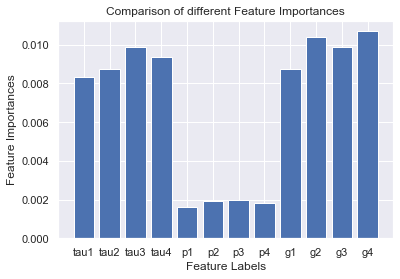

In [48]:
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        ext_clf_1.estimators_], 
                                        axis = 0) 


# Plotting a Bar Graph to compare the models 
plt.bar(X.columns, feature_importance_normalized) 
plt.xlabel('Feature Labels') 
plt.ylabel('Feature Importances') 
plt.title('Comparison of different Feature Importances') 
plt.show()

### XGBoost Classifier

In [18]:
xgb_clf = XGBClassifier(random_state=1)
xgb_clf.fit(normalized_train_df, y_train)
y_pred_xgb = xgb_clf.predict(normalized_test_df)

In [19]:
##from xgboost import plot_tree
##plot_tree(xgb_clf)

In [20]:
cnf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_xgb, labels=['stable', 'unstable'])
cnf = pd.DataFrame(cnf_mat)
cnf.columns = ['Predicted Stable', 'Predicted Unstable']
cnf = cnf.rename(index={0: 'Actual STABLE', 1: 'Actual UNSTABLE'})
cnf

,Predicted Stable,Predicted Unstable
Actual STABLE,648,64
Actual UNSTABLE,45,1243


In [34]:
print(classification_report(y_true=y_test, y_pred=y_pred_xgb, digits=4))

              precision    recall  f1-score   support

      stable     0.9351    0.9101    0.9224       712
    unstable     0.9510    0.9651    0.9580      1288

    accuracy                         0.9455      2000
   macro avg     0.9430    0.9376    0.9402      2000
weighted avg     0.9453    0.9455    0.9453      2000



### Lightgbm Classifier

In [22]:
lgb_clf = LGBMClassifier(random_state=1)
lgb_clf.fit(normalized_train_df, y_train)
y_pred_lgb = xgb_clf.predict(normalized_test_df)

In [23]:
cnf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_lgb, labels=['stable', 'unstable'])
cnf = pd.DataFrame(cnf_mat)
cnf.columns = ['Predicted Stable', 'Predicted Unstable']
cnf = cnf.rename(index={0: 'Actual STABLE', 1: 'Actual UNSTABLE'})
cnf

,Predicted Stable,Predicted Unstable
Actual STABLE,648,64
Actual UNSTABLE,45,1243


In [33]:
print(classification_report(y_true=y_test, y_pred=y_pred_lgb, digits=4))

              precision    recall  f1-score   support

      stable     0.9351    0.9101    0.9224       712
    unstable     0.9510    0.9651    0.9580      1288

    accuracy                         0.9455      2000
   macro avg     0.9430    0.9376    0.9402      2000
weighted avg     0.9453    0.9455    0.9453      2000

